In [1]:
%%time
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

find = lambda arg : os.popen(f"find {arg}").read().split('\n')
grep = lambda pat, ls : list(filter(lambda i : re.search(pat, i) is not None, ls))
grepv = lambda pat, ls : list(filter(lambda i : re.search(pat, i) is None, ls))

walk = find('experiment-a/') + find('experiment-b/')
not_struc = grepv('[A-Z]{25}', walk)
score_paths = [i for i in not_struc if 'scores.csv' in i]
config_paths = [i for i in not_struc if 'config.json' in i]



scores_n_configs = {i:j for i in config_paths for j in score_paths \
                         if os.path.dirname(i) == os.path.dirname(j)}
scores_n_configs

CPU times: user 2.8 s, sys: 214 ms, total: 3.01 s
Wall time: 4 s


{'experiment-a/runs/nlhxn/config.json': 'experiment-a/runs/nlhxn/scores.csv',
 'experiment-a/runs/scbao/config.json': 'experiment-a/runs/scbao/scores.csv',
 'experiment-a/runs/dtkuq/config.json': 'experiment-a/runs/dtkuq/scores.csv',
 'experiment-a/runs/mnlyx/config.json': 'experiment-a/runs/mnlyx/scores.csv',
 'experiment-a/runs/yrpxa/config.json': 'experiment-a/runs/yrpxa/scores.csv',
 'experiment-a/runs/ezrai/config.json': 'experiment-a/runs/ezrai/scores.csv',
 'experiment-a/runs/adoid/config.json': 'experiment-a/runs/adoid/scores.csv',
 'experiment-a/runs/lsnfi/config.json': 'experiment-a/runs/lsnfi/scores.csv',
 'experiment-a/runs/pjmzx/config.json': 'experiment-a/runs/pjmzx/scores.csv',
 'experiment-a/runs/eqpnm/config.json': 'experiment-a/runs/eqpnm/scores.csv',
 'experiment-a/runs/ckutl/config.json': 'experiment-a/runs/ckutl/scores.csv',
 'experiment-b/runs/lxdvr/config.json': 'experiment-b/runs/lxdvr/scores.csv',
 'experiment-b/runs/gnbak/config.json': 'experiment-b/runs/gnbak

In [2]:
import json

def readj(path):
    with open(path) as f:
        return json.load(f)
    
cfg = pd.DataFrame([readj(i) for i in config_paths])
cfg.head()

,POP_SIZE,N_GENERATIONS,SURVIVAL,EXHAUSTIVENESS,VOCAB,MXN_SITES,OUTDIR,SCOREFN
0,128,32,0.25,16,ACDEFGHIKLMNPQRSTVWY,"[47, 49, 51, 75, 78, 88, 94, 138, 142, 175, 17...",runs/nlhxn,NaN
1,8,5,0.25,1,ACDEFGHIKLMNPQRSTVWY,"[47, 49, 51, 75, 78, 88, 94, 138, 142, 175, 17...",runs/scbao,NaN
2,128,32,0.25,16,ACDEFGHIKLMNPQRSTVWY,"[47, 49, 51, 75, 78, 88, 94, 138, 142, 175, 17...",runs/dtkuq,NaN
3,128,32,0.25,16,ACDEFGHIKLMNPQRSTVWY,"[47, 49, 51, 75, 78, 88, 94, 138, 142, 175, 17...",runs/mnlyx,NaN
4,128,32,0.25,16,ACDEFGHIKLMNPQRSTVWY,"[47, 49, 51, 75, 78, 88, 94, 138, 142, 175, 17...",runs/yrpxa,NaN


In [12]:
len(full_runs['a'])

8

In [17]:
actual_col_order = ['gene', 'aff_mean', 'dist_mean','score', 'ham', 'uid']
full_runs = {'a':{}, 'b':{}}
for i in scores_n_configs:
    cfg_ = readj(i)
    pop_size_ = cfg_['POP_SIZE']
    n_generations = cfg_['N_GENERATIONS']
    gens = [i for i in range(n_generations) for j in range(pop_size_)]
    run_name = os.path.dirname(i).split('/')[-1]
    experiment = os.path.dirname(i).split('/')[0].split('-')[-1]
    df_ = pd.read_csv(scores_n_configs[i])
    if experiment == 'a':
        df_.columns = actual_col_order
    df_['generation'] = gens[:len(df_)]
    if len(df_) > pop_size_ * 4:
        full_runs[experiment][run_name] = df_

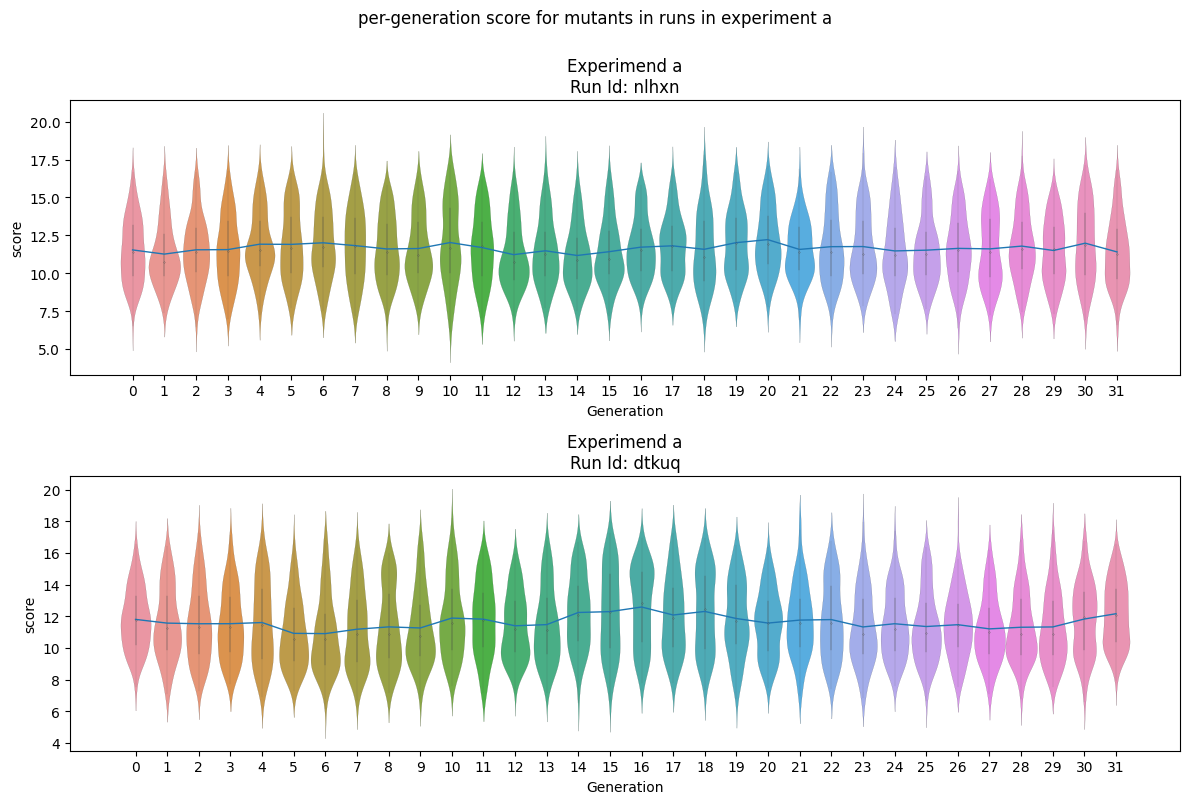

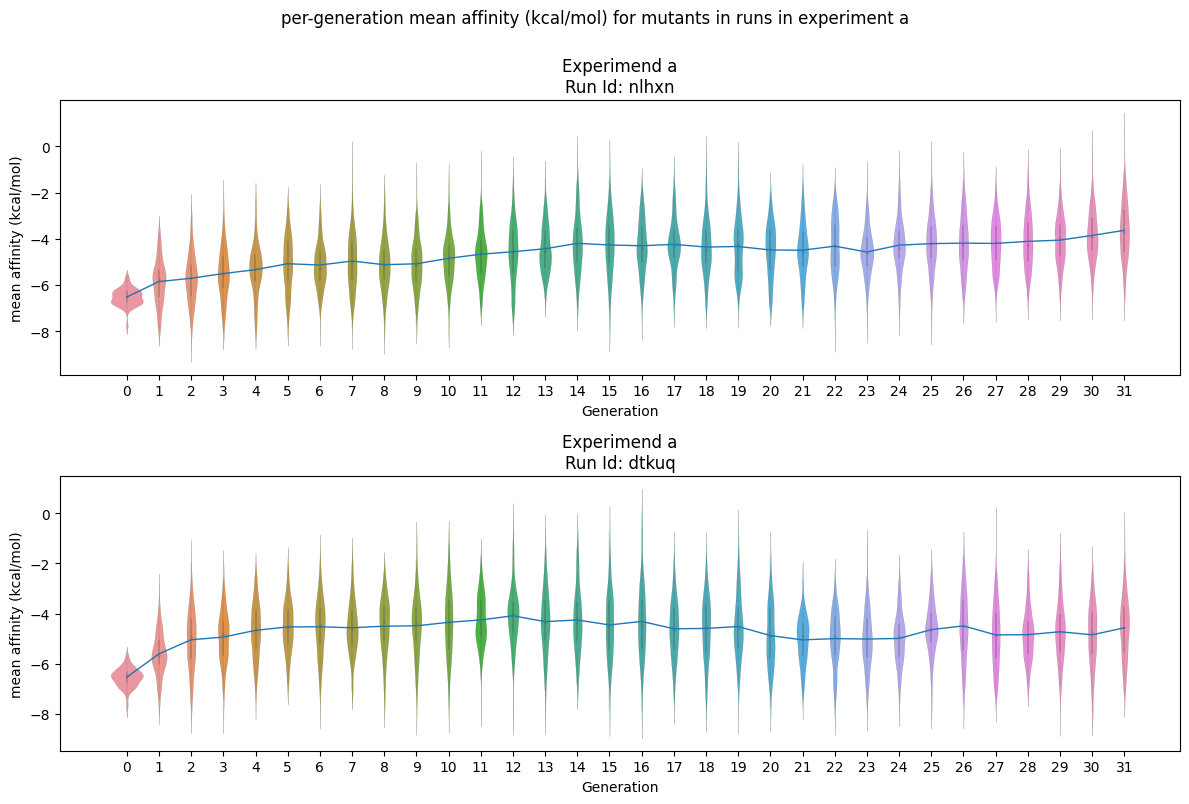

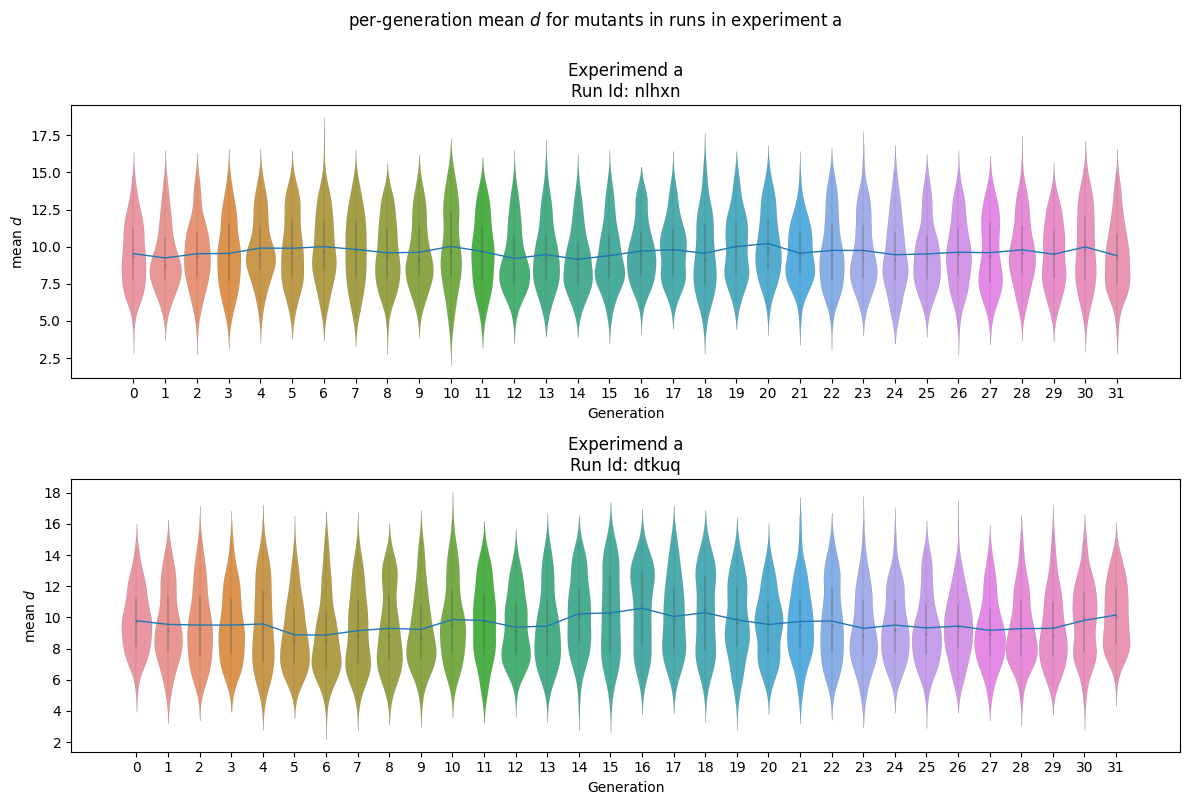

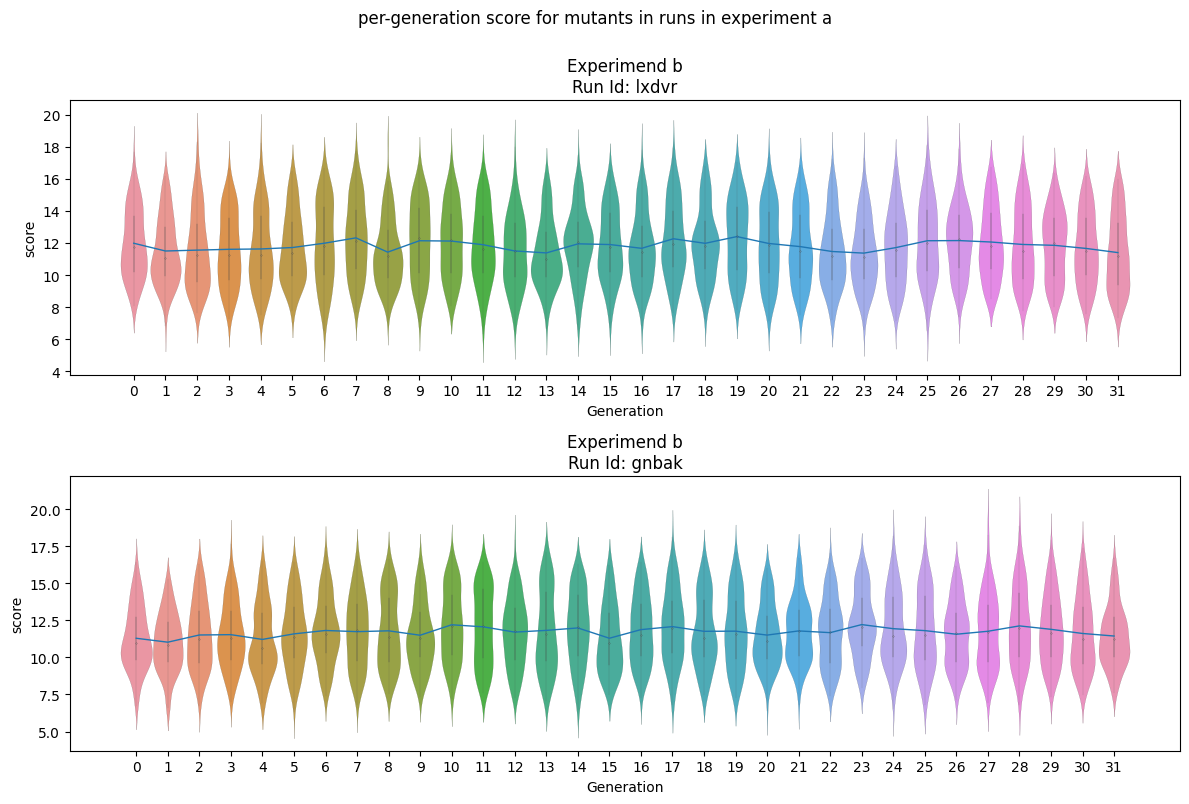

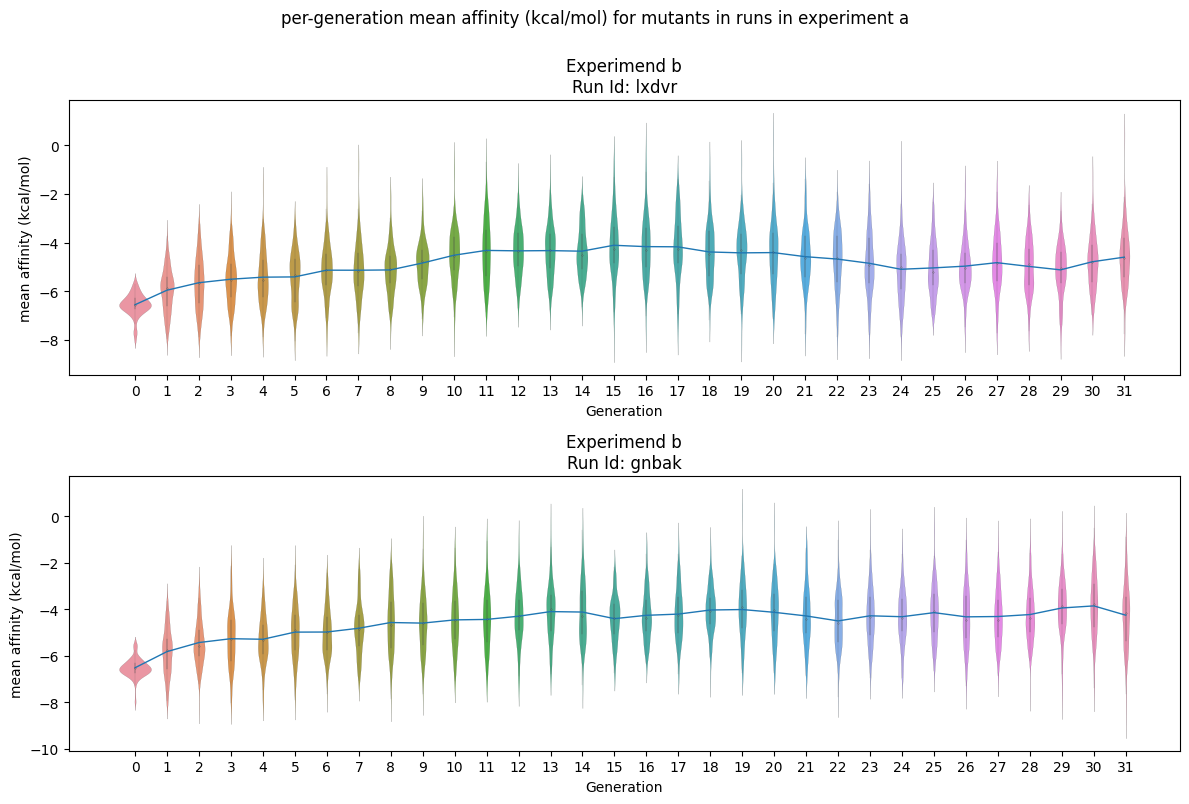

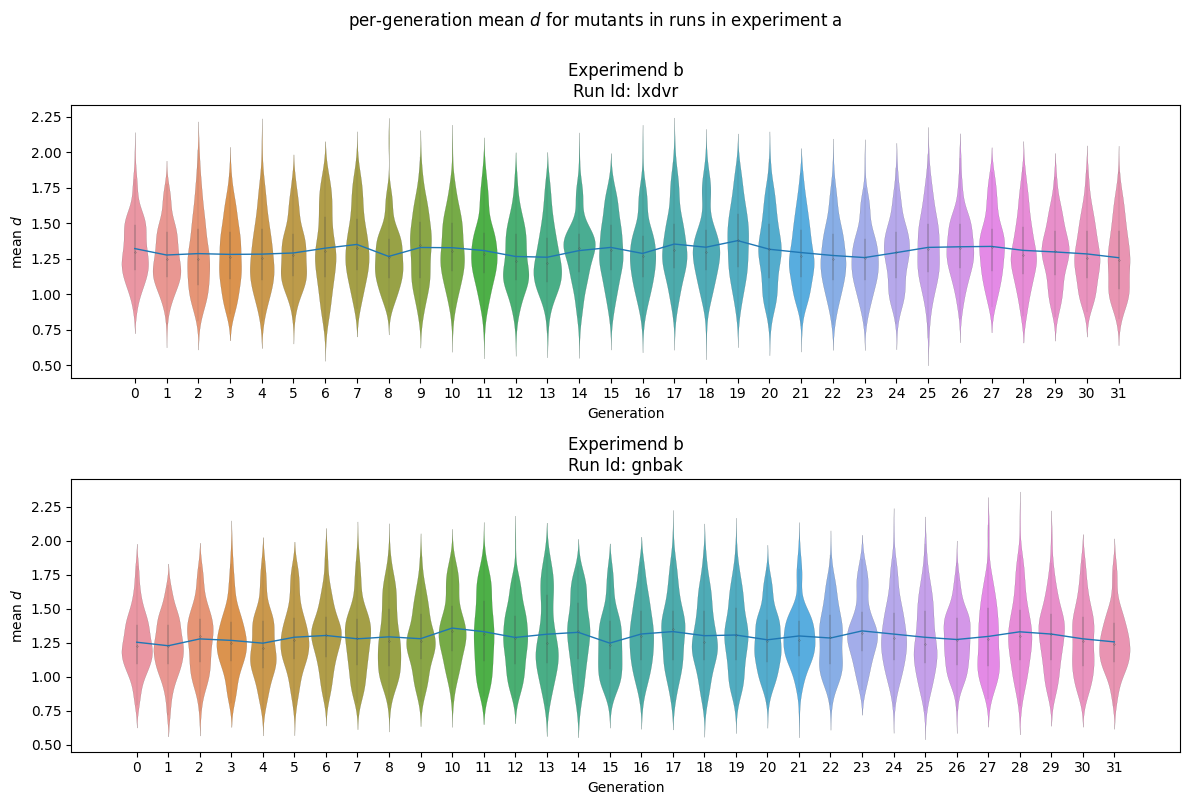

In [15]:
plt.style.use('default')

        
for experiment in 'ab':
    for metric, name in zip(['score', 'aff_mean','dist_mean'],
                            ['score', 'mean affinity (kcal/mol)', 'mean $d$']):
        fig, ax = plt.subplots(len(full_runs),
                               1,
                               figsize=(12,8),
                              )
        for i,j in zip(ax.flatten(), full_runs[experiment]):
            df_ = full_runs[experiment][j]
            sns.violinplot(x=df_['generation'],
                           y=df_[metric],
                           linewidth=0.1,
                           width=1.,
                           ax=i
                          )
            i.plot(\
        [df_.loc[df_['generation']==i,metric].mean() for i in set(df_['generation'])],
                   lw=1,

                    )
            i.set_title(f"Experimend {experiment}\nRun Id: {j}")
            i.set_xlabel('Generation')
            i.set_ylabel(name)


        fig.suptitle(f'Per-Generation {name} for Mutants in Runs in Experiment $A$',
                    x=0.5,
                    y=1)
        plt.tight_layout()
        plt.savefig(f'img/generation-{metric}-{experiment}.png')
        plt.show()

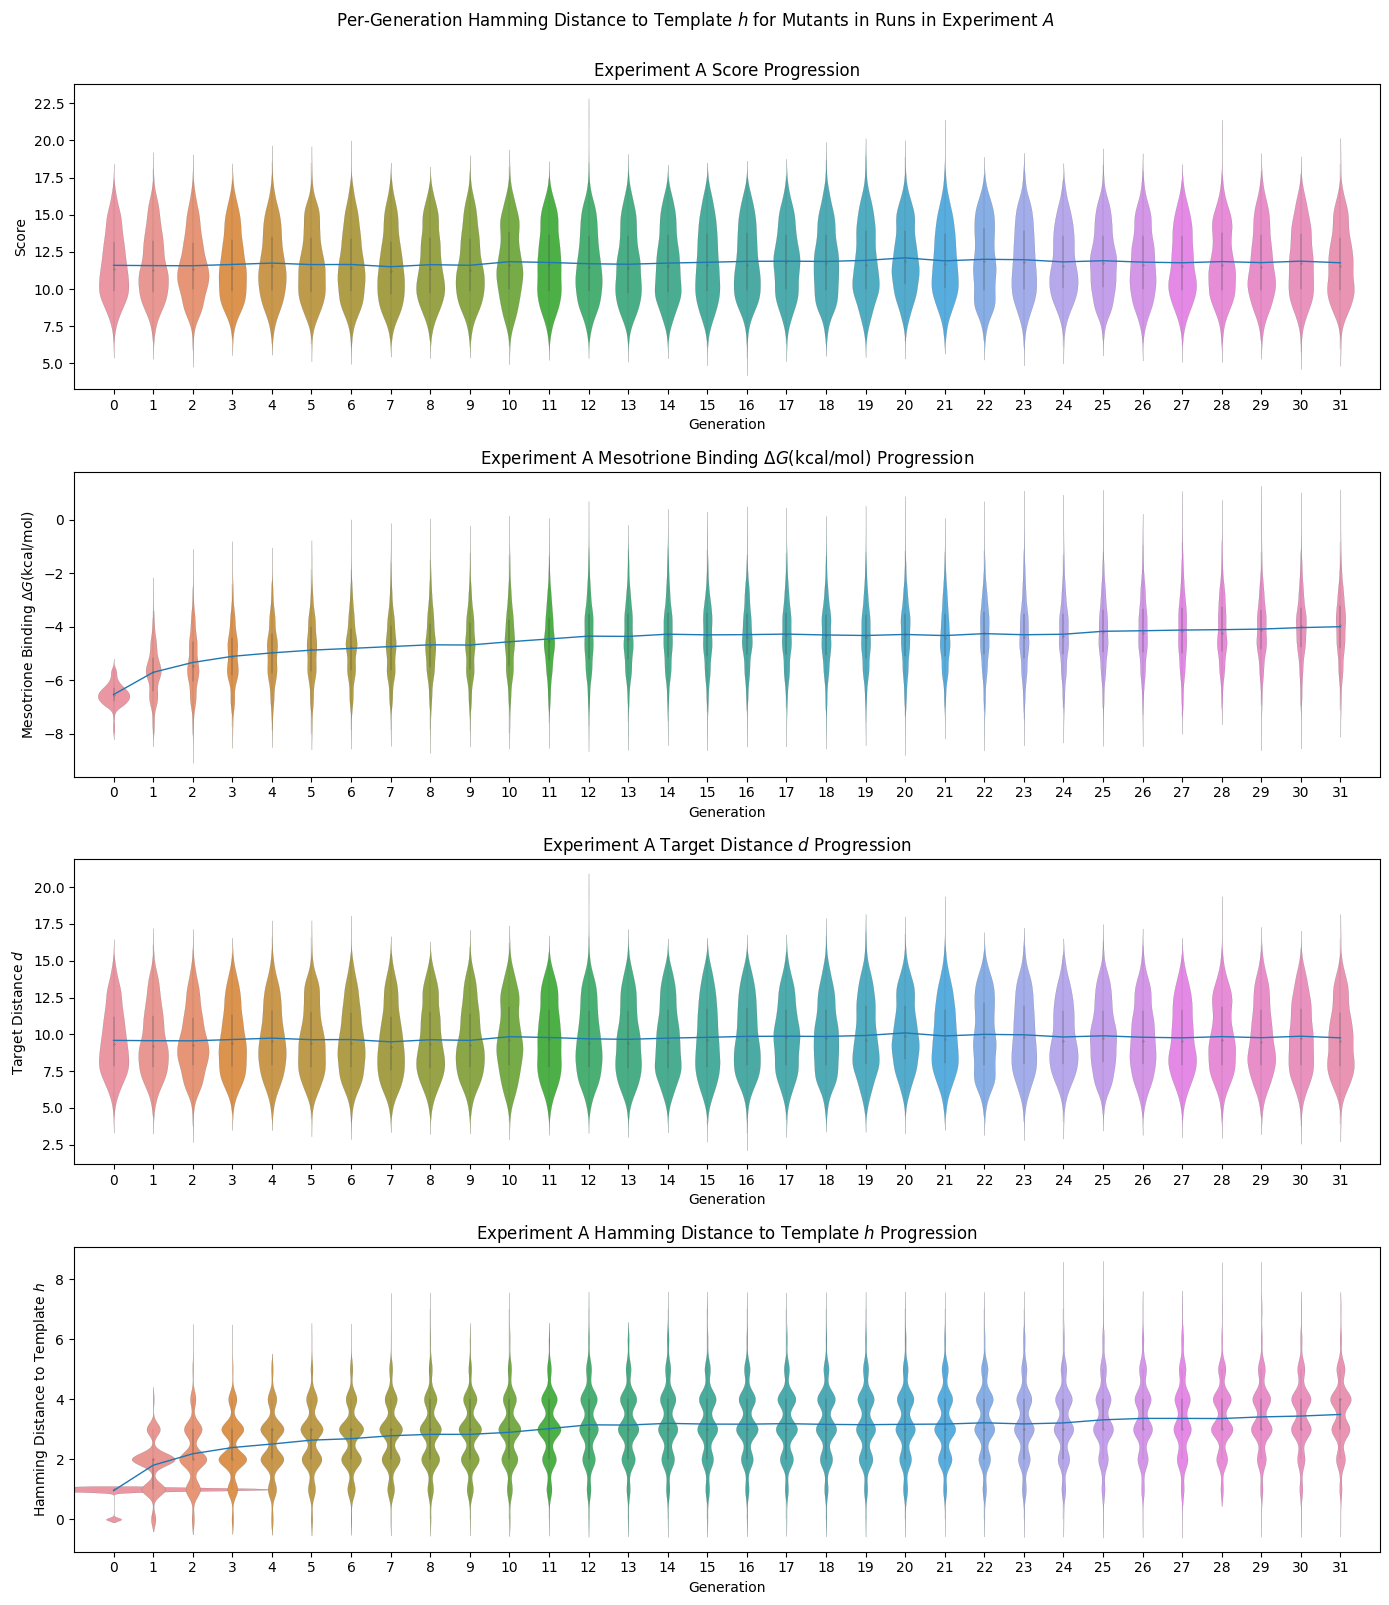

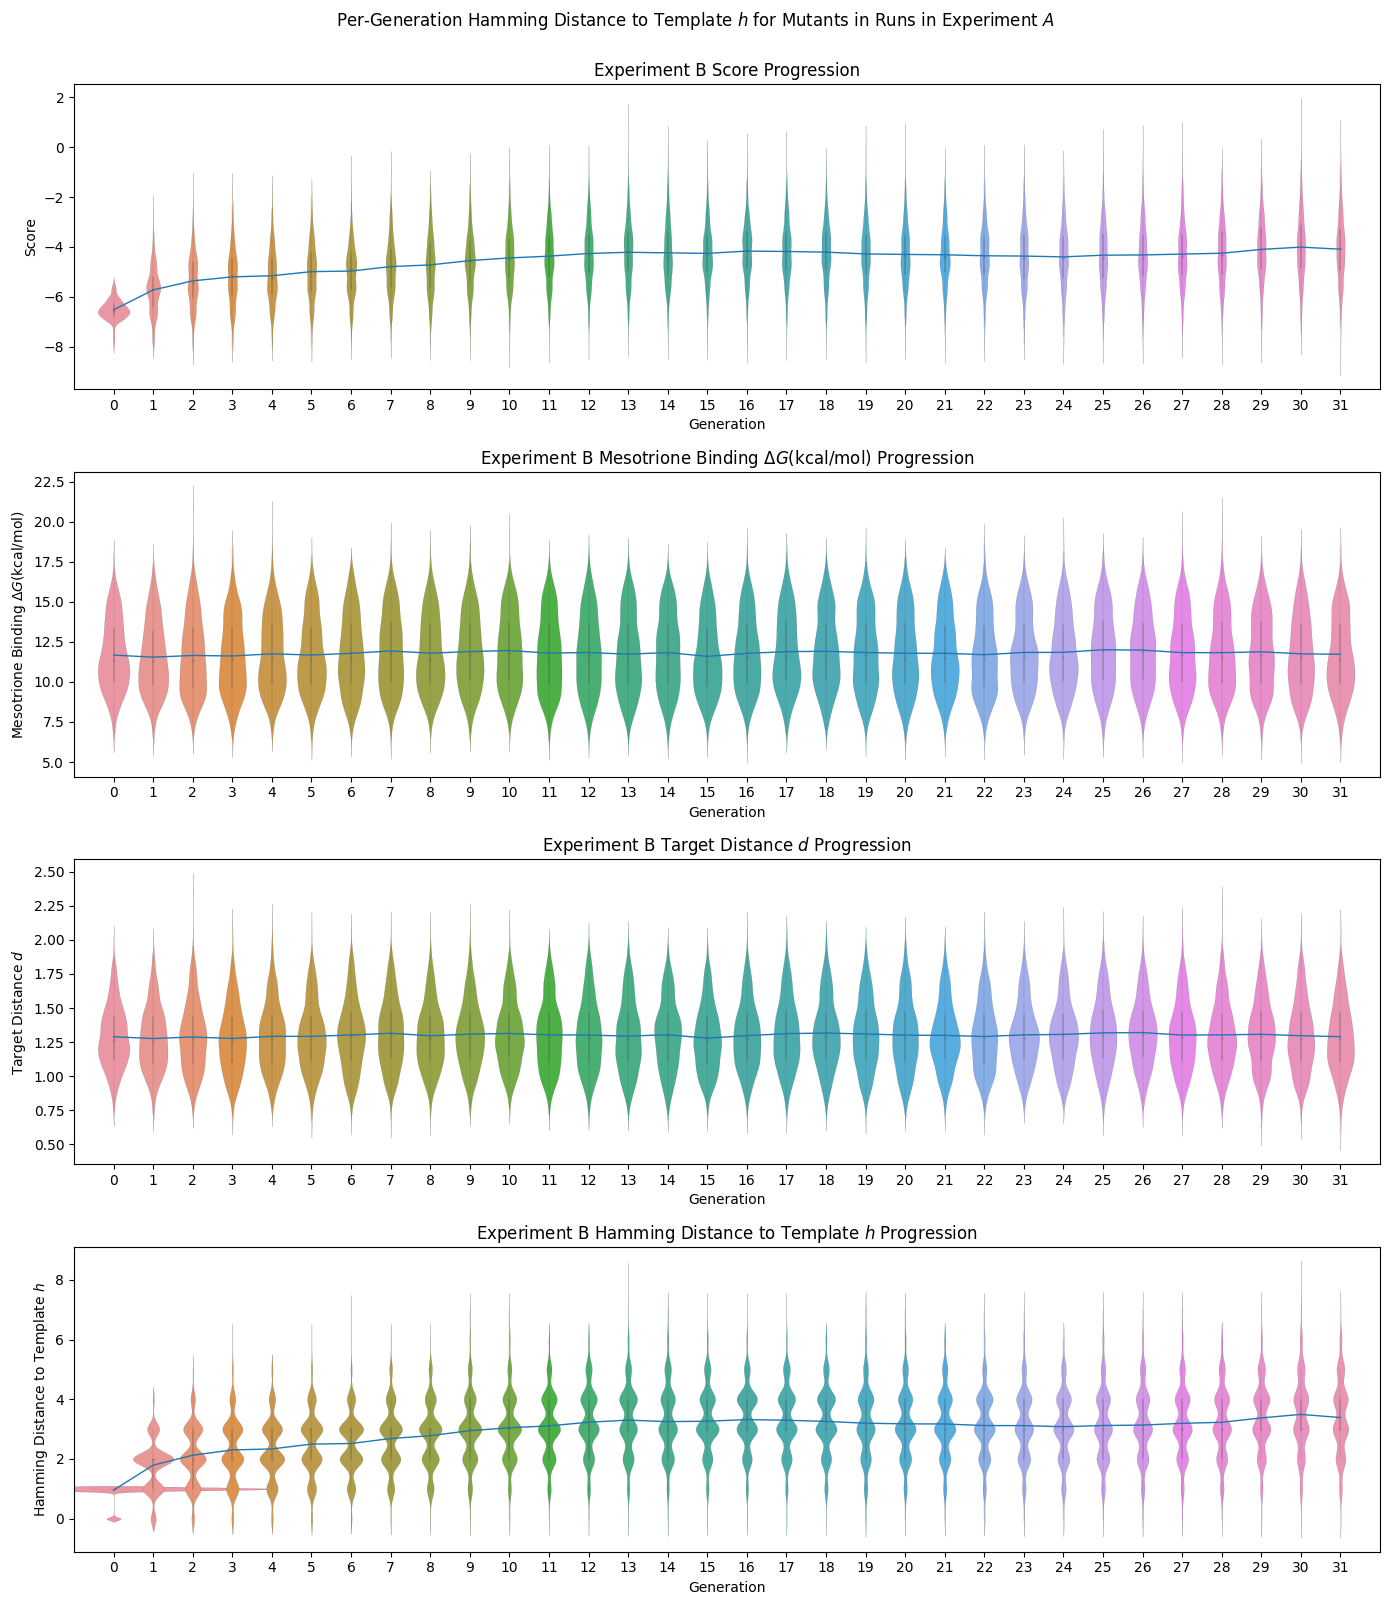

In [33]:
for experiment in 'ab':
    df = pd.concat(full_runs[experiment].values()).reset_index(drop=True)
    fig, ax = plt.subplots(4,
                           1,
                           figsize=(14,16),
                          )
    for metric, name, ax_ in zip(['score', 'aff_mean','dist_mean', 'ham'],
        ['Score', 'Mesotrione Binding $\Delta G$(kcal/mol)', 'Target Distance $d$', 'Hamming Distance to Template $h$'],
                                ax.flatten()):
        
        sns.violinplot(x=df['generation'],
                       y=df[metric],
                       linewidth=0.1,
                       width=dict(zip(['score', 'aff_mean','dist_mean', 'ham'],
                                      [0.8,0.8,0.8,8]))[metric],
                       ax=ax_
                      )
        ax_.plot(\
    [df.loc[df['generation']==i,metric].mean() for i in set(df['generation'])],
               lw=1,

                )
        ax_.set_title(f"Experiment {experiment.upper()} {name} Progression")
        ax_.set_xlabel('Generation')
        ax_.set_ylabel(name)
        ax_.set_xlim(-1, max(df['generation'])+1)


    fig.suptitle(f'Per-Generation {name} for Mutants in Runs in Experiment $A$',
                x=0.5,
                y=1)
    plt.tight_layout()
    plt.savefig(f'img/generation-global-{metric}-{experiment}.png')
    plt.show()